## Importing modules

In [111]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for webscraping import Beautiful Soup 
from bs4 import BeautifulSoup

import xml

# !conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

# !conda install -c conda-forge tqdm
from tqdm import tqdm

import re
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
print('Libraries imported.')

Libraries imported.


## Webscraping neighborhood data

#### First Download the data

In [112]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_districts_and_neighbourhoods_of_Los_Angeles').text
soup = BeautifulSoup(url,"html.parser")
wiki_lis = []
for li in soup.findAll('li'):
    if li.find(href="/wiki/Portal:Los_Angeles"):
        break
    if li.find(href=re.compile("^/wiki/")):
        wiki_lis.append(li)
    if li.text=='Pico Robertson[34]': #Pico Robertson is the only item on the list that does not have a hyperlink reference
        wiki_lis.append(li)
wiki_lis[0:5]

[<li><a href="/wiki/Angelino_Heights,_Los_Angeles" title="Angelino Heights, Los Angeles">Angelino Heights</a><small><sup>[TG]</sup></small></li>,
 <li><a href="/wiki/Arleta,_Los_Angeles" title="Arleta, Los Angeles">Arleta</a><small><sup>[MLA]</sup></small><small><sup>[TG]</sup></small></li>,
 <li><a href="/wiki/Arlington_Heights,_Los_Angeles" title="Arlington Heights, Los Angeles">Arlington Heights</a><small><sup>[MLA]</sup></small></li>,
 <li><a href="/wiki/Arts_District,_Los_Angeles" title="Arts District, Los Angeles">Arts District</a><sup class="reference" id="cite_ref-VisitorsMap_1-0"><a href="#cite_note-VisitorsMap-1">[1]</a></sup></li>,
 <li><a href="/wiki/Atwater_Village,_Los_Angeles" title="Atwater Village, Los Angeles">Atwater Village</a><small><sup>[MLA]</sup></small></li>]

#### Then put the data in dataframe and clean it

In [113]:
neigh = []
for i in range(0,len(wiki_lis)):
    neigh.append(wiki_lis[i].text.strip())
    
wiki_df = pd.DataFrame(neigh)
wiki_df.columns = ['Neighbourhood']

print(wiki_df[:5])
print()
print("###################")
print()
wiki_df['Neighbourhood'] = wiki_df.Neighbourhood.str.partition('[')[0] #Removes the brackets

print(wiki_df[:5])

            Neighbourhood
0    Angelino Heights[TG]
1         Arleta[MLA][TG]
2  Arlington Heights[MLA]
3        Arts District[1]
4    Atwater Village[MLA]

###################

       Neighbourhood
0   Angelino Heights
1             Arleta
2  Arlington Heights
3      Arts District
4    Atwater Village


### find neighborhods in LA with longitude and latitude data

Please note that this block take some time to run

In [115]:
# define the data frame columns
column_names = ['Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the data frame
all_neighborhoods = pd.DataFrame(columns=column_names)

geolocator = Nominatim(user_agent="la_explorer",timeout=10)
# print("Need to process {} neighboorhood".format(len(df)))
for i in tqdm(range(0,len(df))):
#     print("Processing neighboorhood #{}".format(i))
    address = wiki_df.Neighbourhood[i]+', Los Angeles'
    try:
        location = geolocator.geocode(address)
    except:
        # continue of it times out, just don't add that neighborhood
        pass
    if location == None:
        pass
    else:
        latitude = location.latitude
        longitude = location.longitude
        all_neighborhoods = all_neighborhoods.append({'Neighbourhood': df.Neighbourhood[i],
                                                  'Latitude': latitude,
                                                  'Longitude': longitude}, ignore_index=True)
#         print(location)

100%|██████████| 196/196 [02:58<00:00,  1.10it/s]


#### Drop the neighborhoods that are obviously way beyond the coordinate of LA by manual observation coordinates from Google Map

In [116]:
all_neighborhoods=all_neighborhoods[(all_neighborhoods.Latitude>33.5) & (all_neighborhoods.Latitude<34.4) & (all_neighborhoods.Longitude<-118)] 
all_neighborhoods.reset_index(inplace=True,drop=True)

In [117]:
address = 'Los Angeles, USA'

geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinates of Los Angeles, USA are 34.0536909, -118.2427666.


In [118]:
# create map of LA using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighbourhood in zip(all_neighborhoods['Latitude'], all_neighborhoods['Longitude'], all_neighborhoods['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#141452',
        fill_opacity=0.3,
        parse_html=False).add_to(map_la)  
    
map_la

### Foursquare integration

In [123]:
CLIENT_ID = 'SECRET' # Foursquare ID
CLIENT_SECRET = 'SECRET' # Foursquare Secret
VERSION = '20200101' # Foursquare API version

#### Define a function that will take in the name, lat, long values and search all the venues around it

In [124]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Please note that this line may take a while

In [125]:
la_venues = getNearbyVenues(names=all_neighborhoods['Neighbourhood'],
                            latitudes=all_neighborhoods['Latitude'],
                            longitudes=all_neighborhoods['Longitude']
                            )

In [126]:
la_venues[:5]

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Angelino Heights,34.070289,-118.254796,Halliwell Manor,34.069329,-118.254165,Performing Arts Venue
1,Angelino Heights,34.070289,-118.254796,Guisados,34.070262,-118.250437,Taco Place
2,Angelino Heights,34.070289,-118.254796,Eightfold Coffee,34.071245,-118.250698,Coffee Shop
3,Angelino Heights,34.070289,-118.254796,Subliminal Projects,34.072290,-118.250737,Art Gallery
4,Angelino Heights,34.070289,-118.254796,Tsubaki,34.072938,-118.251298,Japanese Restaurant


#### Find the most popular venues

In [75]:
la_venues_count=la_venues.groupby('Neighbourhood').count()
la_venues_count.drop(la_venues_count.columns[[0,1,3,4,5]], axis=1,inplace=True)
la_venues_count.reset_index(inplace=True)
most_popular_neighborhood = la_venues_count[(la_venues_count.Venue>=10)]
most_popular_neighborhood.reset_index(drop=True,inplace=True)
most_popular_neighborhood = most_popular_neighborhood.sort_values(by=['Venue'],ascending=False)
most_popular_neighborhood

,Neighbourhood,Venue
69,Toy District,100
43,Little Tokyo,100
36,Jewelry District,100
35,Historic Core,100
28,Gallery Row,100
25,Financial District,100
8,Bunker Hill,90
60,Sherman Oaks,86
13,Century City,83
46,Mid-Wilshire,79


In [129]:
pop_list=most_popular_neighborhood['Neighbourhood'].values.tolist()

for i in range(len(la_venues)):
    if la_venues.iloc[i,0] not in pop_list:
        la_venues.iloc[i,0]='TO DROP'

la_venues=la_venues[la_venues.Neighbourhood!='TO DROP']
la_venues.reset_index(drop=True,inplace=True)
la_venues[:5]

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Angelino Heights,34.070289,-118.254796,Halliwell Manor,34.069329,-118.254165,Performing Arts Venue
1,Angelino Heights,34.070289,-118.254796,Guisados,34.070262,-118.250437,Taco Place
2,Angelino Heights,34.070289,-118.254796,Eightfold Coffee,34.071245,-118.250698,Coffee Shop
3,Angelino Heights,34.070289,-118.254796,Subliminal Projects,34.072290,-118.250737,Art Gallery
4,Angelino Heights,34.070289,-118.254796,Tsubaki,34.072938,-118.251298,Japanese Restaurant


In [130]:
print('There are {} unique categories.'.format(len(la_venues['Venue Category'].unique())))

There are 311 unique categories.


#### Flatten the list out to construct a table of neighborhoods and different venues

In [131]:
# one hot encoding
la_onehot = pd.get_dummies(la_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to data frame
la_onehot['Neighbourhood'] = la_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]

la_grouped = la_onehot.groupby('Neighbourhood').mean().reset_index()
la_grouped[:10]

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Football Field,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donburi Restaurant,Dongbei Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Rest

#### Printing each neighbourhood along with the top 5 most common venues: -

In [82]:
num_top_venues = 5

for hood in la_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = la_grouped[la_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['VENUE','FREQ']
    temp = temp.iloc[1:]
    temp['FREQ'] = temp['FREQ'].astype(float)
    temp = temp.round({'FREQ': 2})
    print(temp.sort_values('FREQ', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Angelino Heights----
                    VENUE  FREQ
0              Taco Place  0.10
1      Mexican Restaurant  0.07
2             Coffee Shop  0.03
3            Cocktail Bar  0.03
4  Thrift / Vintage Store  0.03


----Arts District----
                VENUE  FREQ
0         Coffee Shop  0.09
1  Italian Restaurant  0.09
2        Cocktail Bar  0.06
3         Art Gallery  0.06
4            Pie Shop  0.03


----Atwater Village----
                 VENUE  FREQ
0          Coffee Shop  0.07
1                  Gym  0.05
2  Sporting Goods Shop  0.05
3          Pizza Place  0.05
4           Restaurant  0.05


----Baldwin Hills/Crenshaw----
                 VENUE  FREQ
0       Discount Store  0.05
1          Pizza Place  0.05
2          Gas Station  0.05
3  Sporting Goods Shop  0.05
4           Food Truck  0.05


----Beverly Hills Post Office----
                 VENUE  FREQ
0   Italian Restaurant  0.07
1                Hotel  0.07
2                 Park  0.05
3     Sushi Restaurant  0.04
4  

                                      VENUE  FREQ
0                                Art Museum  0.14
1  Residential Building (Apartment / Condo)  0.14
2                                    Museum  0.07
3                         Convenience Store  0.07
4                             Historic Site  0.07


----Playa Vista----
        VENUE  FREQ
0  Food Truck  0.26
1        Park  0.15
2         Gym  0.09
3        Café  0.09
4        Pool  0.06


----Playa del Rey----
                  VENUE  FREQ
0  Gym / Fitness Center  0.15
1           Pizza Place  0.08
2             Speakeasy  0.08
3       Automotive Shop  0.08
4          Liquor Store  0.08


----Reseda----
                   VENUE  FREQ
0  Vietnamese Restaurant  0.18
1     Chinese Restaurant  0.09
2           Noodle House  0.05
3               Pharmacy  0.05
4         Massage Studio  0.05


----Rustic Canyon----
                 VENUE  FREQ
0                Beach  0.19
1  American Restaurant  0.11
2                Trail  0.11
3   Italian

#### Creating a new data frame and displaying the top 10 venues for each neighbourhood: -

In [87]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [89]:
num_top_venues = 10

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    columns.append('#{} most common venue'.format(ind+1))

# create a new data frame
Neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
Neighbourhoods_venues_sorted['Neighbourhood'] = la_grouped['Neighbourhood']

for ind in np.arange(la_grouped.shape[0]):
    Neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

Neighbourhoods_venues_sorted.head()

,Neighbourhood,#1 most common venue,#2 most common venue,#3 most common venue,#4 most common venue,#5 most common venue,#6 most common venue,#7 most common venue,#8 most common venue,#9 most common venue,#10 most common venue
0,Angelino Heights,Taco Place,Mexican Restaurant,Pet Store,Clothing Store,Cocktail Bar,Sculpture Garden,Coffee Shop,Boutique,Thrift / Vintage Store,Park
1,Arts District,Italian Restaurant,Coffee Shop,Cocktail Bar,Art Gallery,Residential Building (Apartment / Condo),Performing Arts Venue,Brewery,Café,Smoothie Shop,Climbing Gym
2,Atwater Village,Coffee Shop,Sporting Goods Shop,Theater,Gym,Restaurant,Pizza Place,Pet Store,Cuban Restaurant,Farmers Market,Chinese Restaurant
3,Baldwin Hills/Crenshaw,Light Rail Station,Coffee Shop,Food Truck,Burger Joint,Food,Miscellaneous Shop,Mexican Restaurant,Gas Station,Fast Food Restaurant,Theater
4,Beverly Hills Post Office,Hotel,Italian Restaurant,Park,American Restaurant,New American Restaurant,Sushi Restaurant,Coffee Shop,Spa,Café,Dessert Shop


### Clustering

Using Silhouette Coefficient method --> higher Silhoutte Coefficient means that the model is more inter-related, and poorly matched to other neighboring clusters

In [90]:
from sklearn.metrics import silhouette_score

la_grouped_clustering = la_grouped.drop('Neighbourhood', 1)

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(la_grouped_clustering)
    label = kmeans.labels_
    sil_coeff = silhouette_score(la_grouped_clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.03943016614523913
For n_clusters=3, The Silhouette Coefficient is 0.06618405261290451
For n_clusters=4, The Silhouette Coefficient is 0.12915219472183007
For n_clusters=5, The Silhouette Coefficient is 0.12646912870626212
For n_clusters=6, The Silhouette Coefficient is 0.21014874785400156
For n_clusters=7, The Silhouette Coefficient is 0.15710220156440838
For n_clusters=8, The Silhouette Coefficient is 0.10254608128171826
For n_clusters=9, The Silhouette Coefficient is 0.0778292520432597


In my case, *K=6* achieves the best result

In [91]:
kclusters = 6

la_grouped_clustering = la_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)

Creating a new data frame that includes the cluster as well as the top 10 venues for each neighbourhood: -

In [92]:
# add clustering labels
Neighbourhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_.astype(int))
# Neighbourhoods_venues_sorted['Cluster Label']=kmeans.labels_.astype(int)
la_merged = all_neighborhoods

# merge la_grouped with nhoods to add latitude/longitude for each Neighbourhood
la_merged = la_merged.join(Neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
la_merged.dropna(inplace=True)
la_merged['Cluster Label'] = la_merged['Cluster Label'].astype(int)
la_merged.head() 

,Neighbourhood,Latitude,Longitude,Cluster Label,#1 most common venue,#2 most common venue,#3 most common venue,#4 most common venue,#5 most common venue,#6 most common venue,#7 most common venue,#8 most common venue,#9 most common venue,#10 most common venue
0,Angelino Heights,34.070289,-118.254796,1,Taco Place,Mexican Restaurant,Pet Store,Clothing Store,Cocktail Bar,Sculpture Garden,Coffee Shop,Boutique,Thrift / Vintage Store,Park
3,Arts District,34.041239,-118.234450,1,Italian Restaurant,Coffee Shop,Cocktail Bar,Art Gallery,Residential Building (Apartment / Condo),Performing Arts Venue,Brewery,Café,Smoothie Shop,Climbing Gym
4,Atwater Village,34.116398,-118.256464,1,Coffee Shop,Sporting Goods Shop,Theater,Gym,Restaurant,Pizza Place,Pet Store,Cuban Restaurant,Farmers Market,Chinese Restaurant
6,Baldwin Hills/Crenshaw,34.023176,-118.334248,1,Light Rail Station,Coffee Shop,Food Truck,Burger Joint,Food,Miscellaneous Shop,Mexican Restaurant,Gas Station,Fast Food Restaurant,Theater
11,Beverly Hills Post Office,34.069650,-118.396306,1,Hotel,Italian Restaurant,Park,American Restaurant,New American Restaurant,Sushi Restaurant,Coffee Shop,Spa,Café,Dessert Shop


In [98]:
import matplotlib.colors as colors
from matplotlib.colors import rgb2hex
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow[2]='#006000'
rainbow[1]='#006ff6'
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['Neighbourhood'], la_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 100px; left: 50px; width: 120px; height: 80px; 
                            border:3px solid black; z-index:9999; font-size:13px;
                            ">&nbsp; Green - Cluster 0 <br>
                              &nbsp; Red - Cluster 1 <br>
                              &nbsp; Purple - Cluster 2 <br>
                              &nbsp; Blue - Cluster 3 </i>
                </div>
                ''' 

map_clusters.get_root().html.add_child(folium.Element(legend_html))
map_clusters

In [100]:
la_merged.loc[la_merged['Cluster Label'] == 0, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]
la_merged.loc[la_merged['Cluster Label'] == 1, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]
la_merged.loc[la_merged['Cluster Label'] == 2, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]
la_merged.loc[la_merged['Cluster Label'] == 3, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]
la_results = pd.DataFrame(kmeans.cluster_centers_)
la_results.columns = la_grouped_clustering.columns
la_results.index = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']
la_results['Total Sum'] = la_results.sum(axis = 1)
la_results

,ATM,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Football Field,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donburi Restaurant,Dongbei Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning

In [101]:

def generate_plot(clus,i):
    
    plt.style.use('default')

    tags=['Restaurant','Coffee','Food','Pizza','Sandwich']
    colors = []
    for value in clus.index: 
        if  any(t in value for t in tags):
            colors.append('#a80000')
        else:
            colors.append('#32069f')

    ax=clus.plot(kind='barh', figsize=(16,8), color=colors, alpha=0.7)

    plt.title('(in % of all venues)\n')
    ax.title.set_fontsize(14)
    plt.suptitle('Ten Most Prevalent Venues of Cluster {}'.format(i), fontsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.xticks([])
    ax.tick_params(axis ='both', which ='both', length = 0)
    labels = [(item.get_text()+'  ') for item in ax.get_yticklabels()]
    ax.set_yticklabels(labels)

    for label in (ax.get_yticklabels()):
        label.set_fontsize(12)

    for index, value in enumerate(clus): 
        label = "%.1f " % round(value*100,1) + "%"
        # place text at the end of bar (adding 0.001 to x, and 0.1 from y to make it appear just after the bar)
        plt.annotate(label, xy=(value + 0.001, index - 0.1), color='black',fontsize=12)

    legend_elements = [Patch(facecolor='#a80000', edgecolor='#a80000',
                             label='Food Venues',alpha=0.7),
                       Patch(facecolor='#32069f', edgecolor='#32069f',
                             label='Others',alpha=0.7)]

    ax.legend(handles=legend_elements, loc='best',fontsize=12)

    plt.show()

#### Displaying the data for each cluster

,Mexican Restaurant,Fast Food Restaurant,Convenience Store,Sandwich Place,Grocery Store,Pizza Place,Video Store,Park,Burger Joint,Pharmacy,Bank,Donut Shop,Restaurant,Chinese Restaurant,Gym / Fitness Center,Café,Gas Station,Food,Liquor Store,Korean Restaurant,Bakery,Ice Cream Shop,Spa,Shipping Store,Mobile Phone Shop,Sushi Restaurant,Latin American Restaurant,Women's Store,Automotive Shop,Fried Chicken Joint,Intersection,Thrift / Vintage Store,Hotel,American Restaurant,Discount Store,Food Truck,Supermarket,Filipino Restaurant,South American Restaurant,Nail Salon,Clothing Store,Diner,Waterfront,Asian Restaurant,Insurance Office,Music Venue,Sculpture Garden,Fabric Shop,Motel,Gym,Auto Garage,Sports Bar,Health & Beauty Service,Marijuana Dispensary,Flower Shop,Speakeasy,Laundromat,Other Great Outdoors,Pool,Bar,Cajun / Creole Restaurant,Creperie,Vietnamese Restaurant,Rock Club,Dry Cleaner,Cosmetics Shop,Thai Restaurant,Seafood Restaurant,Taco Place,Coffee Shop,Tanning Salon,Juice Bar,Bubble Tea Shop,Hawaiian Restaurant,Playground,Karaoke Bar,Paper / Office Supplies Store,Breakfast Spot,Check Cashing Service,Bookstore,Gay Bar,Rental Car Location,Residential Building (Apartment / Condo),Martial Arts Dojo,Dive Bar,Hardware Store,Middle Eastern Restaurant,North Indian Restaurant,Hot Dog Joint,ATM,Shoe Store,Theater,Performing Arts Venue,Deli / Bodega,Snack Place,Harbor / Marina,Skate Park,Nightclub,Buffet,Market,Art Gallery,Cocktail Bar,Pet Store,History Museum,Arts & Crafts Store,Boutique,Brewery,Indian Restaurant,Gastropub,Smoke Shop,Movie Theater,Accessories Store,Business Service,Recreation Center,Shopping Mall,Miscellaneous Shop,Noodle House,Hookah Bar,Beach,Music Store,Optical Shop,Construction & Landscaping,Toy / Game Store,Poke Place,Design Studio,Tree,Board Shop,Big Box Store,Shop & Service,Greek Restaurant,Gourmet Shop,Garden,Rental Service,Fish Market,Salad Place,Food & Drink Shop,Cantonese Restaurant,Dog Run,Kids Store,Pool Hall,Baby Store,Udon Restaurant,Taiwanese Restaurant,Strip Club,Beer Store,Gym Pool,Fountain,Photography Studio,Spanish Restaurant,Kosher Restaurant,Tattoo Parlor,Shoe Repair,Public Art,Irish Pub,Dim Sum Restaurant,Astrologer,Gymnastics Gym,Cheese Shop,Halal Restaurant,Golf Course,Bistro,Stationery Store,Yoshoku Restaurant,Library,Shabu-Shabu Restaurant,Vape Store,Train,School,Kitchen Supply Store,Hobby Shop,Tunnel,College Academic Building,Caribbean Restaurant,Salon / Barbershop,Climbing Gym,Roof Deck,Science Museum,Concert Hall,Indie Movie Theater,Comedy Club,Comic Shop,Cafeteria,Recording Studio,Cuban Restaurant,Cycle Studio,Dance Studio,Plaza,Department Store,Dessert Shop,Candy Store,Indonesian Restaurant,Shopping Plaza,Tailor Shop,Adult Boutique,Wine Shop,Airport Terminal,Volleyball Court,Track,Art Museum,Athletics & Sports,BBQ Joint,Baseball Field,Basketball Court,Smoothie Shop,Szechuan Restaurant,Basketball Stadium,Surf Spot,Bed & Breakfast,Beer Bar,Pie Shop,Beer Garden,Southern / Soul Food Restaurant,Soup Place,Stadium,Road,Neighborhood,Electronics Store,Lingerie Store,Lounge,Jewelry Store,Falafel Restaurant,Laundry Service,French Restaurant,Gun Range,Flea Market,Outdoor Sculpture,Event Space,Moroccan Restaurant,Mediterranean Restaurant,Frozen Yogurt Shop,High School,Donburi Restaurant,Furniture / Home Store,Historic Site,General Entertainment,Food Stand,Soccer Stadium,Soccer Field,Burrito Place,Football Stadium,Sports Club,Bus Stop,Zoo Exhibit,Cemetery,Exhibit,Lake,College Football Field,College Theater,Amphitheater,Antique Shop,Peruvian Restaurant,Dongbei Restaurant,Argentinian Restaurant,Boxing Gym,Video Game Store,Tex-Mex Restaurant,Organic Grocery,Locksmith,Aquarium,Butcher,Opera House,Bus Line,Sake Bar,Dumpling Restaurant,Theme Park,Tea Room,Home Service,Hotel Bar,Train Station,State / Provincial Park,Whisky Bar,Monument / Landmark,Cupcake Shop,Japanese Curry Restaurant,Record Shop,Wings Joint,Pet Café,Scenic Lookout,Building,Bowling Alley,Food Court,Light Rail Station,Men's Store,Jazz Club,O

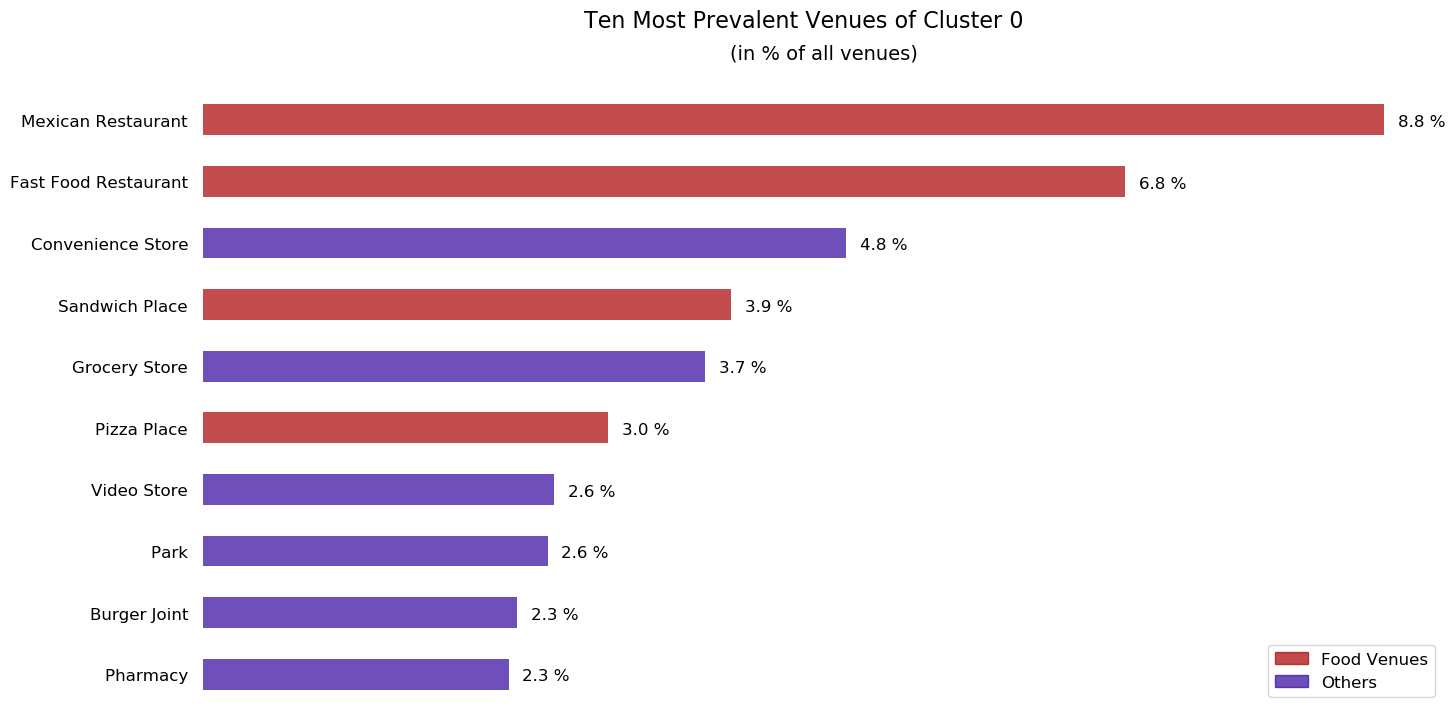

In [104]:
cluster0=pd.DataFrame(la_results.iloc[0,0:-1]).transpose()
cluster0.sort_values(by='Cluster 0',axis=1,ascending=False,inplace=True)
display(cluster0)

clus0=cluster0.iloc[0,9::-1]
generate_plot(clus0,0)

,Coffee Shop,Pizza Place,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Bar,Chinese Restaurant,Food Truck,American Restaurant,Café,Sandwich Place,Grocery Store,Park,Bakery,Ice Cream Shop,Convenience Store,Clothing Store,Gym,Japanese Restaurant,Pharmacy,Restaurant,Art Gallery,Taco Place,Gym / Fitness Center,Yoga Studio,Thai Restaurant,Hotel,Fast Food Restaurant,Burger Joint,Cosmetics Shop,Bank,Video Store,Theater,Pet Store,Juice Bar,Deli / Bodega,Salon / Barbershop,Asian Restaurant,Farmers Market,Cocktail Bar,New American Restaurant,Mediterranean Restaurant,Seafood Restaurant,Breakfast Spot,Arts & Crafts Store,Vegetarian / Vegan Restaurant,Supermarket,Boutique,Thrift / Vintage Store,Music Venue,Furniture / Home Store,Department Store,Gastropub,Historic Site,French Restaurant,Middle Eastern Restaurant,Sporting Goods Shop,Smoke Shop,Vietnamese Restaurant,Spa,Intersection,Museum,Shipping Store,Trail,Residential Building (Apartment / Condo),Gift Shop,Fried Chicken Joint,Steakhouse,Bookstore,BBQ Joint,Indian Restaurant,Brewery,Donut Shop,Plaza,Shoe Store,Gas Station,Wine Bar,Mobile Phone Shop,ATM,Bus Station,Discount Store,Performing Arts Venue,Concert Hall,Dance Studio,Market,Rental Car Location,Lounge,Hot Dog Joint,Hookah Bar,Speakeasy,Frozen Yogurt Shop,Movie Theater,Science Museum,Bubble Tea Shop,Ramen Restaurant,Art Museum,Gay Bar,Beach,Paper / Office Supplies Store,Noodle House,Bagel Shop,Dessert Shop,Nail Salon,Filipino Restaurant,Sports Bar,Wine Shop,Electronics Store,Miscellaneous Shop,Shopping Mall,Latin American Restaurant,Nightclub,Diner,Business Service,Men's Store,Cajun / Creole Restaurant,Salad Place,Neighborhood,Flea Market,Pool,History Museum,Accessories Store,Caribbean Restaurant,Poke Place,Massage Studio,Sculpture Garden,Insurance Office,Gourmet Shop,Other Great Outdoors,Athletics & Sports,Food Court,Recreation Center,Jewelry Store,Liquor Store,Indie Movie Theater,Playground,Garden,Flower Shop,Airport Terminal,Financial or Legal Service,Tree,Indonesian Restaurant,Greek Restaurant,Candy Store,Tiki Bar,Southern / Soul Food Restaurant,Buffet,Food,Supplement Shop,Design Studio,Eastern European Restaurant,Rock Club,Lingerie Store,General Entertainment,Kids Store,Marijuana Dispensary,Pilates Studio,Martial Arts Dojo,Jazz Club,South American Restaurant,Board Shop,Construction & Landscaping,Brazilian Restaurant,Health Food Store,Record Shop,Donburi Restaurant,Karaoke Bar,Health & Beauty Service,Music Store,Dive Bar,Dog Run,Toy / Game Store,Wings Joint,Cupcake Shop,Korean Restaurant,Pub,Food & Drink Shop,Gluten-free Restaurant,Fountain,Optical Shop,Cuban Restaurant,Office,Big Box Store,Hotel Bar,Hawaiian Restaurant,Cafeteria,Gun Range,Climbing Gym,Event Space,Hardware Store,Tailor Shop,College Academic Building,Tea Room,Comedy Club,Whisky Bar,Beer Store,Light Rail Station,Food Stand,Arcade,Taiwanese Restaurant,Women's Store,Japanese Curry Restaurant,Gym Pool,Comic Shop,Spanish Restaurant,State / Provincial Park,Aquarium,Pet Café,Shopping Plaza,Monument / Landmark,Building,Cantonese Restaurant,Bowling Alley,Pool Hall,Baby Store,Skate Park,Road,Surf Spot,Volleyball Court,Track,Bed & Breakfast,Scenic Lookout,Tattoo Parlor,Udon Restaurant,Opera House,Adult Boutique,Motel,Sake Bar,Boxing Gym,Creperie,Auto Garage,Train Station,Soup Place,Baseball Field,Recording Studio,Szechuan Restaurant,Laundry Service,North Indian Restaurant,Beer Garden,Smoothie Shop,Pie Shop,Moroccan Restaurant,Falafel Restaurant,Public Art,Laundromat,Peruvian Restaurant,Bus Line,Locksmith,Butcher,High School,Roof Deck,Cycle Studio,Home Service,Astrologer,Gymnastics Gym,Photography Studio,Dim Sum Restaurant,Tex-Mex Restaurant,Fabric Shop,Cheese Shop,Sports Club,Zoo Exhibit,Soccer Stadium,Football Stadium,Amphitheater,College Football Field,Soccer Field,Exhibit,Lake,Burrito Place,Bus Stop,Dongbei Restaurant,Dumpling Restaurant,Organic Grocery,Theme Park,Irish Pub,Shoe Repair,Golf Course,Snack Place,Stadium,Beer Bar,Outdoor Sculpture,Basketball Stadium

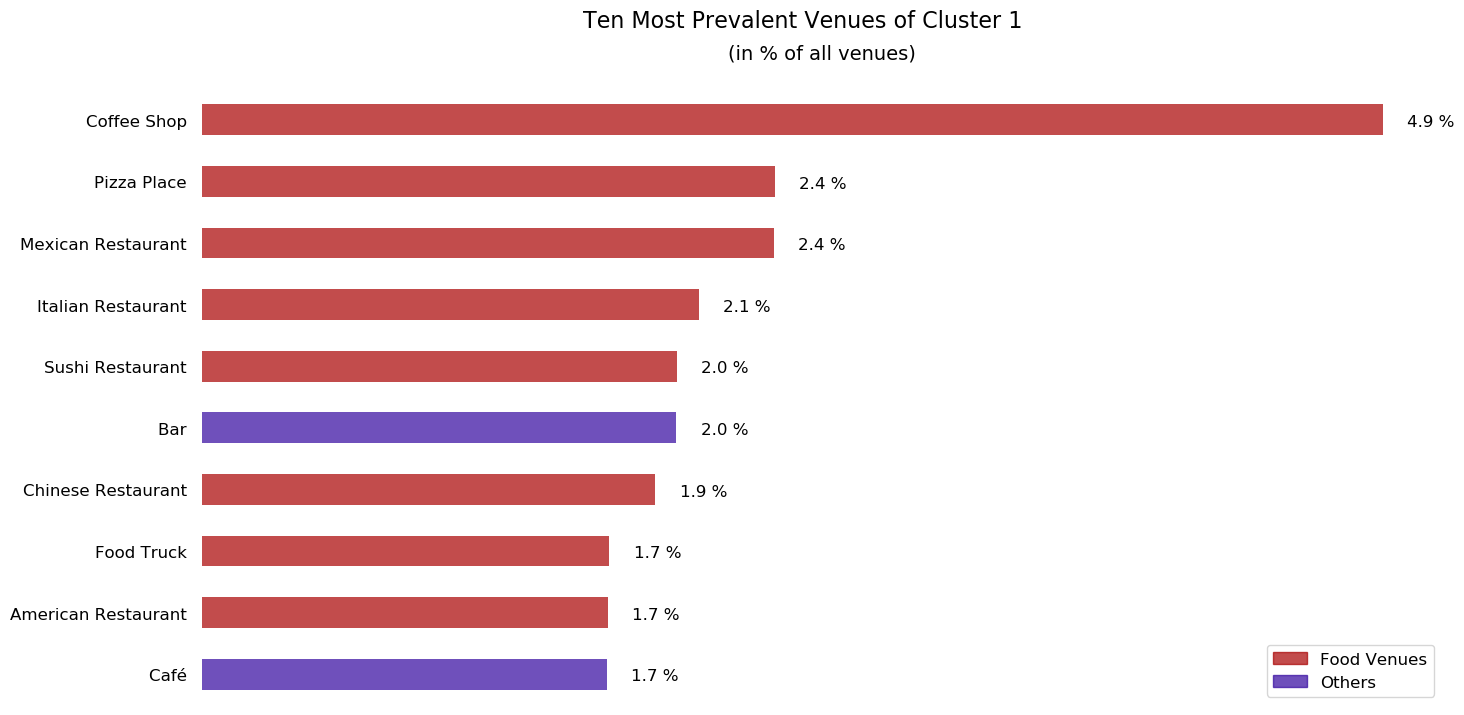

In [105]:
cluster1=pd.DataFrame(la_results.iloc[1,0:-1]).transpose()
cluster1.sort_values(by='Cluster 1',axis=1,ascending=False,inplace=True)
display(cluster1)

clus1=cluster1.iloc[0,9::-1]
generate_plot(clus1,1)

,Thai Restaurant,Café,Massage Studio,Middle Eastern Restaurant,Juice Bar,Marijuana Dispensary,Bar,Sushi Restaurant,Strip Club,Comedy Club,Discount Store,Dessert Shop,Noodle House,Pet Store,Sandwich Place,Food Truck,Asian Restaurant,Mexican Restaurant,Convenience Store,Cocktail Bar,Gym / Fitness Center,Liquor Store,Ice Cream Shop,Department Store,Vegetarian / Vegan Restaurant,Yoga Studio,Bank,Wine Bar,Trail,Outdoor Sculpture,Peruvian Restaurant,Performing Arts Venue,Park,Paper / Office Supplies Store,Other Great Outdoors,Volleyball Court,Organic Grocery,Optical Shop,Opera House,Office,North Indian Restaurant,Waterfront,Pet Café,Pharmacy,Vietnamese Restaurant,New American Restaurant,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Nightclub,Nail Salon,Neighborhood,Market,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Yoshoku Restaurant,Locksmith,Lounge,Women's Store,Martial Arts Dojo,Recreation Center,Wings Joint,Mediterranean Restaurant,Men's Store,Wine Shop,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Whisky Bar,Music Store,Music Venue,Recording Studio,Rental Car Location,Track,Supplement Shop,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Tree,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Train Station,Supermarket,Surf Spot,Soup Place,Train,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tattoo Parlor,Tea Room,Tex-Mex Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,South American Restaurant,Soccer Stadium,Rental Service,Sculpture Garden,Apartment / Condo,Restaurant,Road,Rock Club,Roof Deck,Video Store,Sake Bar,Salad Place,Video Game Store,Salon / Barbershop,Kids Store,Scenic Lookout,School,Science Museum,Seafood Restaurant,Soccer Field,Shabu-Shabu Restaurant,Vape Store,Shipping Store,Shoe Repair,Shoe Store,Udon Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Tunnel,Smoke Shop,Smoothie Shop,Snack Place,ATM,Irish Pub,Karaoke Bar,Check Cashing Service,Caribbean Restaurant,Cantonese Restaurant,Candy Store,Cajun / Creole Restaurant,Cafeteria,Butcher,Business Service,Bus Stop,Bus Station,Bus Line,Burrito Place,Burger Joint,Building,Buffet,Bubble Tea Shop,Cemetery,Cheese Shop,Jewelry Store,Chinese Restaurant,Dance Studio,Cycle Studio,Cupcake Shop,Cuban Restaurant,Creperie,Cosmetics Shop,Construction & Landscaping,Concert Hall,Comic Shop,College Theater,College Football Field,College Academic Building,Coffee Shop,Clothing Store,Climbing Gym,Brewery,Breakfast Spot,Brazilian Restaurant,Boxing Gym,Automotive Shop,Auto Garage,Athletics & Sports,Astrologer,Arts & Crafts Store,Art Museum,Art Gallery,Argentinian Restaurant,Arcade,Aquarium,Antique Shop,Amphitheater,American Restaurant,Airport Terminal,Adult Boutique,BBQ Joint,Baby Store,Bagel Shop,Beer Store,Bowling Alley,Boutique,Bookstore,Board Shop,Bistro,Big Box Store,Beer Garden,Bakery,Beer Bar,Bed & Breakfast,Beach,Basketball Stadium,Basketball Court,Baseball Field,Deli / Bodega,Design Studio,Dim Sum Restaurant,Gift Shop,High School,Health Food Store,Health & Beauty Service,Hawaiian Restaurant,Hardware Store,Harbor / Marina,Halal Restaurant,Gymnastics Gym,Gym Pool,Gym,Gun Range,Grocery Store,Greek Restaurant,Gourmet Shop,Golf Course,Historic Site,History Museum,Hobby Shop,Insurance Office,Jazz Club,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Accessories Store,Intersection,Indonesian Restaurant,Home Service,Indie Movie Theater,Indian Restaurant,Hotel Bar,Hotel,Hot Dog Joint,Hookah Bar,Gluten-free Restaurant,General Entertainment,Diner,Gay Bar,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,Event Space,Electronics Store,Eastern Euro

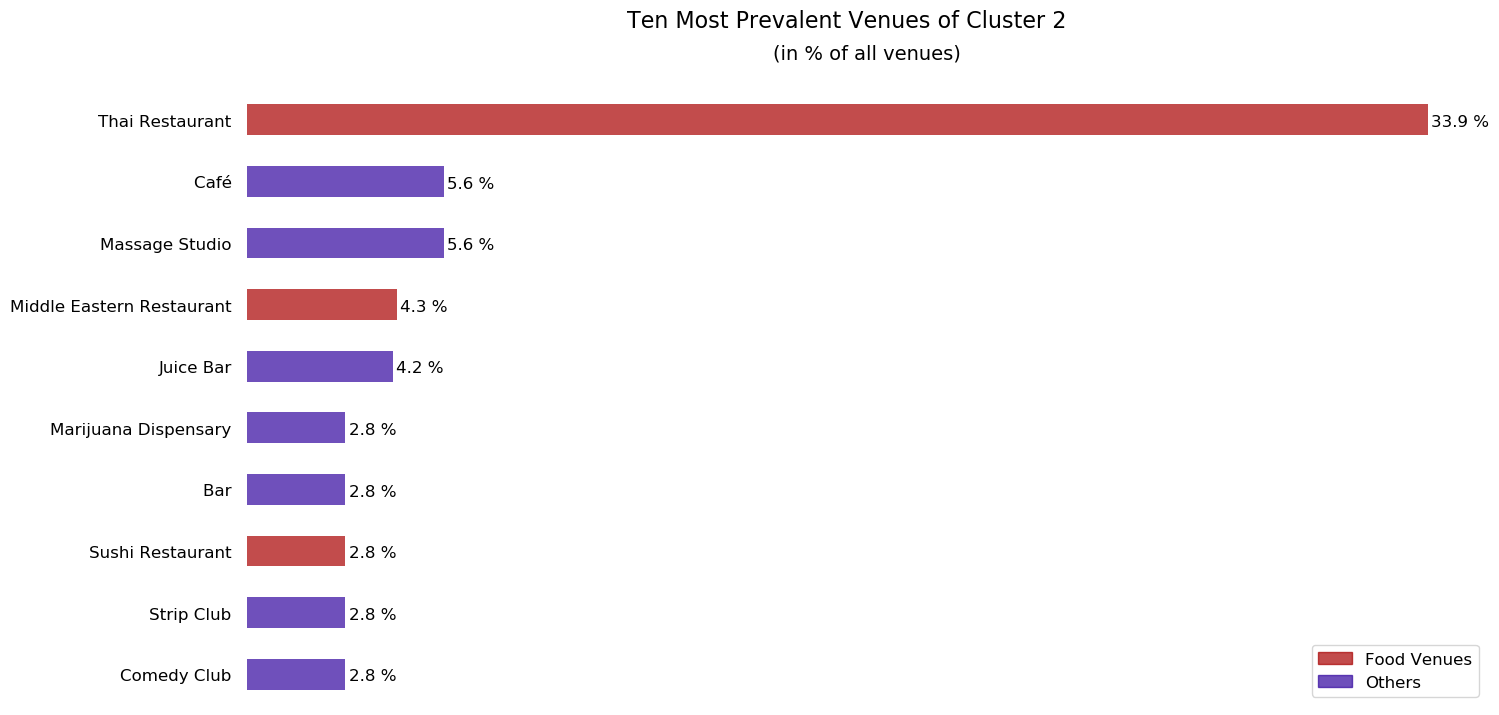

In [106]:
cluster2=pd.DataFrame(la_results.iloc[2,0:-1]).transpose()
cluster2.sort_values(by='Cluster 2',axis=1,ascending=False,inplace=True)
cluster2.rename(columns={'Residential Building (Apartment / Condo)': 'Apartment / Condo'},inplace=True)
display(cluster2)

clus2=cluster2.iloc[0,9::-1]
generate_plot(clus2,2)

,Park,Trail,Sandwich Place,Basketball Court,Rental Service,Grocery Store,Café,Coffee Shop,History Museum,Music Venue,Donut Shop,Art Gallery,Food Truck,Light Rail Station,Pie Shop,Paper / Office Supplies Store,Optical Shop,Performing Arts Venue,Outdoor Sculpture,Peruvian Restaurant,Other Great Outdoors,Pet Café,Pet Store,Pharmacy,Photography Studio,Organic Grocery,ATM,Pilates Studio,Public Art,Residential Building (Apartment / Condo),Rental Car Location,Recreation Center,Recording Studio,Record Shop,Ramen Restaurant,Pub,Pizza Place,Pool Hall,Pool,Poke Place,Plaza,Playground,Office,Opera House,New American Restaurant,North Indian Restaurant,Martial Arts Dojo,Marijuana Dispensary,Lounge,Locksmith,Liquor Store,Lingerie Store,Library,Laundry Service,Laundromat,Latin American Restaurant,Lake,Kosher Restaurant,Korean Restaurant,Kitchen Supply Store,Kids Store,Karaoke Bar,Market,Massage Studio,Noodle House,Mediterranean Restaurant,Nightclub,Road,Neighborhood,Nail Salon,Music Store,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Men's Store,Restaurant,Salad Place,Rock Club,Tex-Mex Restaurant,Track,Toy / Game Store,Tiki Bar,Thrift / Vintage Store,Theme Park,Theater,Thai Restaurant,Tea Room,Roof Deck,Tattoo Parlor,Tanning Salon,Taiwanese Restaurant,Tailor Shop,Taco Place,Szechuan Restaurant,Sushi Restaurant,Train,Train Station,Tree,Tunnel,Yoshoku Restaurant,Yoga Studio,Women's Store,Wings Joint,Wine Shop,Wine Bar,Whisky Bar,Waterfront,Volleyball Court,Vietnamese Restaurant,Video Store,Video Game Store,Vegetarian / Vegan Restaurant,Vape Store,Udon Restaurant,Surf Spot,Supplement Shop,Supermarket,Smoke Shop,Shopping Plaza,Shopping Mall,Shop & Service,Shoe Store,Shoe Repair,Shipping Store,Shabu-Shabu Restaurant,Seafood Restaurant,Sculpture Garden,Science Museum,School,Scenic Lookout,Salon / Barbershop,Jewelry Store,Sake Bar,Skate Park,Smoothie Shop,Strip Club,Snack Place,Steakhouse,Stationery Store,State / Provincial Park,Stadium,Sports Club,Sports Bar,Sporting Goods Shop,Speakeasy,Spanish Restaurant,Spa,Southern / Soul Food Restaurant,South American Restaurant,Soup Place,Soccer Stadium,Soccer Field,Juice Bar,Irish Pub,Jazz Club,Check Cashing Service,Caribbean Restaurant,Cantonese Restaurant,Candy Store,Cajun / Creole Restaurant,Cafeteria,Butcher,Business Service,Bus Stop,Bus Station,Bus Line,Burrito Place,Burger Joint,Building,Buffet,Bubble Tea Shop,Cemetery,Cheese Shop,Breakfast Spot,Chinese Restaurant,Cupcake Shop,Cuban Restaurant,Creperie,Cosmetics Shop,Convenience Store,Construction & Landscaping,Concert Hall,Comic Shop,Comedy Club,College Theater,College Football Field,College Academic Building,Cocktail Bar,Clothing Store,Climbing Gym,Brewery,Brazilian Restaurant,Dance Studio,Baby Store,Automotive Shop,Auto Garage,Athletics & Sports,Astrologer,Asian Restaurant,Arts & Crafts Store,Art Museum,Argentinian Restaurant,Arcade,Aquarium,Antique Shop,Amphitheater,American Restaurant,Airport Terminal,Adult Boutique,BBQ Joint,Bagel Shop,Boxing Gym,Bakery,Bowling Alley,Boutique,Bookstore,Board Shop,Bistro,Big Box Store,Beer Store,Beer Garden,Beer Bar,Bed & Breakfast,Beach,Basketball Stadium,Baseball Field,Bar,Bank,Cycle Studio,Deli / Bodega,Japanese Restaurant,Health Food Store,Hawaiian Restaurant,Hardware Store,Harbor / Marina,Halal Restaurant,Gymnastics Gym,Gym Pool,Gym / Fitness Center,Gym,Gun Range,Greek Restaurant,Gourmet Shop,Golf Course,Gluten-free Restaurant,Gift Shop,General Entertainment,Health & Beauty Service,High School,Gastropub,Historic Site,Japanese Curry Restaurant,Italian Restaurant,Accessories Store,Intersection,Insurance Office,Indonesian Restaurant,Indie Movie Theater,Indian Restaurant,Ice Cream Shop,Hotel Bar,Hotel,Hot Dog Joint,Hookah Bar,Home Service,Hobby Shop,Gay Bar,Gas Station,Department Store,Falafel Restaurant,Exhibit,Event Space,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dry Cleaner,Dongbei Res

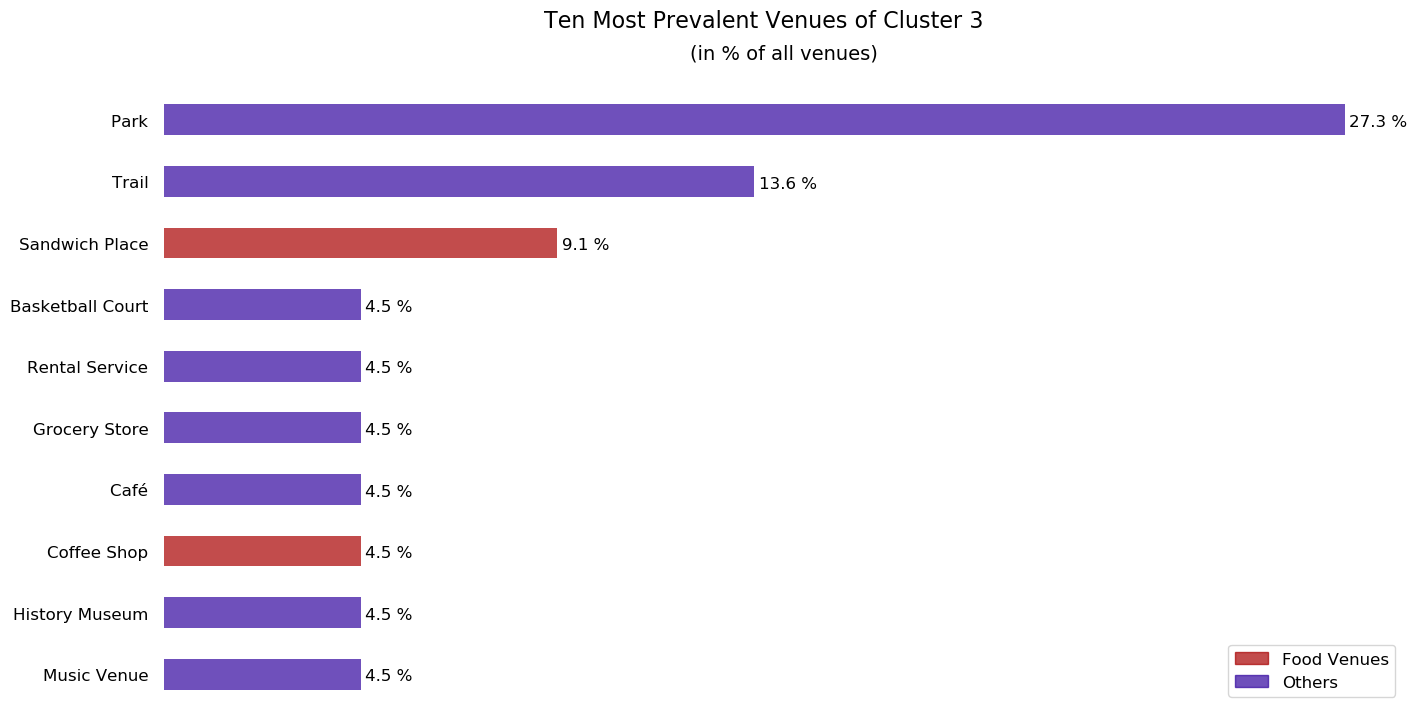

In [107]:
cluster3=pd.DataFrame(la_results.iloc[3,0:-1]).transpose()
cluster3.sort_values(by='Cluster 3',axis=1,ascending=False,inplace=True)
display(cluster3)

clus3=cluster3.iloc[0,9::-1]
generate_plot(clus3,3)

,Park,Trail,Sandwich Place,Basketball Court,Rental Service,Grocery Store,Café,Coffee Shop,History Museum,Music Venue,Donut Shop,Art Gallery,Food Truck,Light Rail Station,Pie Shop,Paper / Office Supplies Store,Optical Shop,Performing Arts Venue,Outdoor Sculpture,Peruvian Restaurant,Other Great Outdoors,Pet Café,Pet Store,Pharmacy,Photography Studio,Organic Grocery,ATM,Pilates Studio,Public Art,Residential Building (Apartment / Condo),Rental Car Location,Recreation Center,Recording Studio,Record Shop,Ramen Restaurant,Pub,Pizza Place,Pool Hall,Pool,Poke Place,Plaza,Playground,Office,Opera House,New American Restaurant,North Indian Restaurant,Martial Arts Dojo,Marijuana Dispensary,Lounge,Locksmith,Liquor Store,Lingerie Store,Library,Laundry Service,Laundromat,Latin American Restaurant,Lake,Kosher Restaurant,Korean Restaurant,Kitchen Supply Store,Kids Store,Karaoke Bar,Market,Massage Studio,Noodle House,Mediterranean Restaurant,Nightclub,Road,Neighborhood,Nail Salon,Music Store,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Men's Store,Restaurant,Salad Place,Rock Club,Tex-Mex Restaurant,Track,Toy / Game Store,Tiki Bar,Thrift / Vintage Store,Theme Park,Theater,Thai Restaurant,Tea Room,Roof Deck,Tattoo Parlor,Tanning Salon,Taiwanese Restaurant,Tailor Shop,Taco Place,Szechuan Restaurant,Sushi Restaurant,Train,Train Station,Tree,Tunnel,Yoshoku Restaurant,Yoga Studio,Women's Store,Wings Joint,Wine Shop,Wine Bar,Whisky Bar,Waterfront,Volleyball Court,Vietnamese Restaurant,Video Store,Video Game Store,Vegetarian / Vegan Restaurant,Vape Store,Udon Restaurant,Surf Spot,Supplement Shop,Supermarket,Smoke Shop,Shopping Plaza,Shopping Mall,Shop & Service,Shoe Store,Shoe Repair,Shipping Store,Shabu-Shabu Restaurant,Seafood Restaurant,Sculpture Garden,Science Museum,School,Scenic Lookout,Salon / Barbershop,Jewelry Store,Sake Bar,Skate Park,Smoothie Shop,Strip Club,Snack Place,Steakhouse,Stationery Store,State / Provincial Park,Stadium,Sports Club,Sports Bar,Sporting Goods Shop,Speakeasy,Spanish Restaurant,Spa,Southern / Soul Food Restaurant,South American Restaurant,Soup Place,Soccer Stadium,Soccer Field,Juice Bar,Irish Pub,Jazz Club,Check Cashing Service,Caribbean Restaurant,Cantonese Restaurant,Candy Store,Cajun / Creole Restaurant,Cafeteria,Butcher,Business Service,Bus Stop,Bus Station,Bus Line,Burrito Place,Burger Joint,Building,Buffet,Bubble Tea Shop,Cemetery,Cheese Shop,Breakfast Spot,Chinese Restaurant,Cupcake Shop,Cuban Restaurant,Creperie,Cosmetics Shop,Convenience Store,Construction & Landscaping,Concert Hall,Comic Shop,Comedy Club,College Theater,College Football Field,College Academic Building,Cocktail Bar,Clothing Store,Climbing Gym,Brewery,Brazilian Restaurant,Dance Studio,Baby Store,Automotive Shop,Auto Garage,Athletics & Sports,Astrologer,Asian Restaurant,Arts & Crafts Store,Art Museum,Argentinian Restaurant,Arcade,Aquarium,Antique Shop,Amphitheater,American Restaurant,Airport Terminal,Adult Boutique,BBQ Joint,Bagel Shop,Boxing Gym,Bakery,Bowling Alley,Boutique,Bookstore,Board Shop,Bistro,Big Box Store,Beer Store,Beer Garden,Beer Bar,Bed & Breakfast,Beach,Basketball Stadium,Baseball Field,Bar,Bank,Cycle Studio,Deli / Bodega,Japanese Restaurant,Health Food Store,Hawaiian Restaurant,Hardware Store,Harbor / Marina,Halal Restaurant,Gymnastics Gym,Gym Pool,Gym / Fitness Center,Gym,Gun Range,Greek Restaurant,Gourmet Shop,Golf Course,Gluten-free Restaurant,Gift Shop,General Entertainment,Health & Beauty Service,High School,Gastropub,Historic Site,Japanese Curry Restaurant,Italian Restaurant,Accessories Store,Intersection,Insurance Office,Indonesian Restaurant,Indie Movie Theater,Indian Restaurant,Ice Cream Shop,Hotel Bar,Hotel,Hot Dog Joint,Hookah Bar,Home Service,Hobby Shop,Gay Bar,Gas Station,Department Store,Falafel Restaurant,Exhibit,Event Space,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dry Cleaner,Dongbei Res

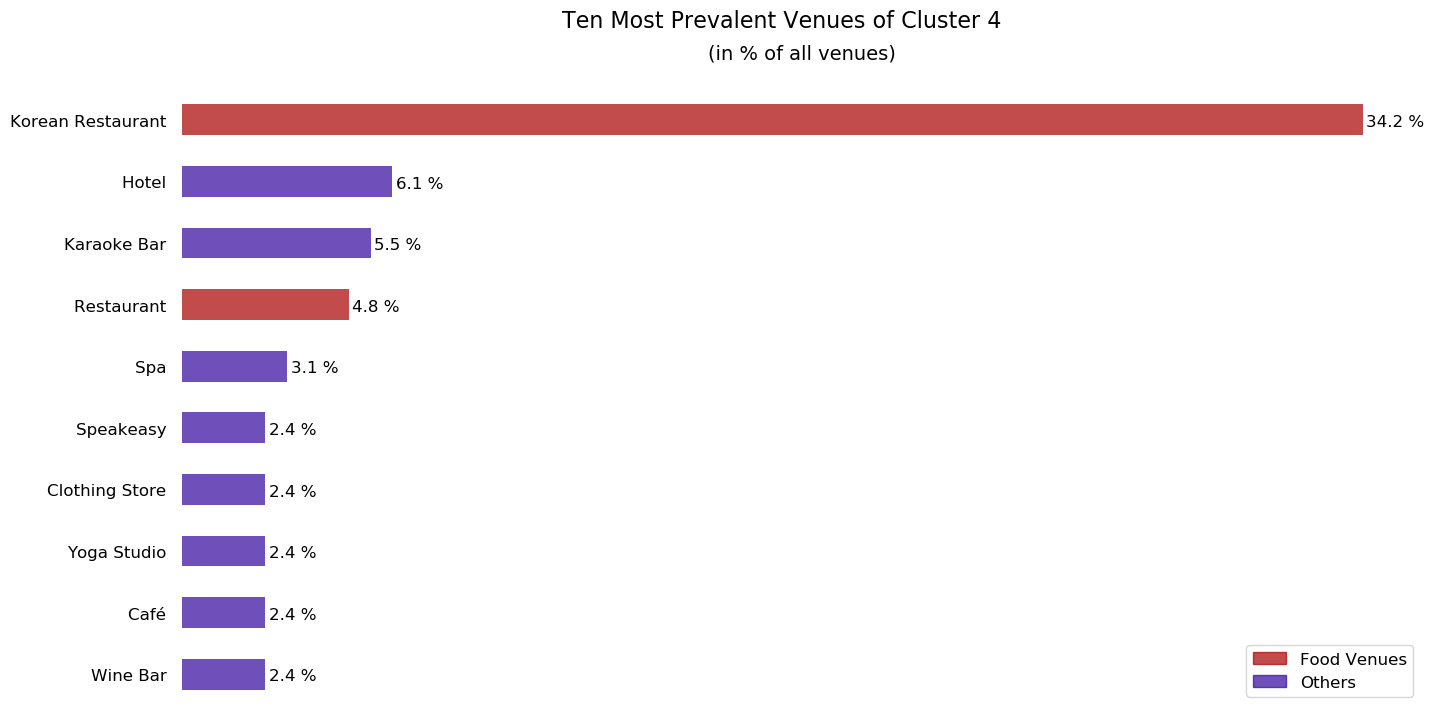

In [108]:
cluster4=pd.DataFrame(la_results.iloc[4,0:-1]).transpose()
cluster4.sort_values(by='Cluster 4',axis=1,ascending=False,inplace=True)
display(cluster3)

clus4=cluster4.iloc[0,9::-1]
generate_plot(clus4,4)

,Mobile Phone Shop,Pizza Place,Pharmacy,Sandwich Place,Bank,Diner,Chinese Restaurant,American Restaurant,Indian Restaurant,Shoe Store,Filipino Restaurant,Café,Cosmetics Shop,Middle Eastern Restaurant,Mexican Restaurant,Fast Food Restaurant,Intersection,Shop & Service,Fried Chicken Joint,Fish Market,Cuban Restaurant,Rental Car Location,Home Service,Yoga Studio,Fabric Shop,Hotel,Kosher Restaurant,Convenience Store,Burger Joint,Sushi Restaurant,Music Venue,Gas Station,Martial Arts Dojo,Gym / Fitness Center,Gym,Asian Restaurant,Discount Store,Clothing Store,Snack Place,Supplement Shop,Video Game Store,Video Store,Bakery,Deli / Bodega,Pet Store,Sporting Goods Shop,Speakeasy,Salad Place,Poke Place,Gourmet Shop,Record Shop,Wings Joint,Fountain,Baby Store,Spanish Restaurant,Golf Course,Tunnel,Train,School,Bistro,Pub,Public Art,Plaza,Playground,Photography Studio,Pie Shop,Pilates Studio,Ramen Restaurant,Pool,Pool Hall,ATM,Pet Café,Movie Theater,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Miscellaneous Shop,Moroccan Restaurant,Motel,Museum,Peruvian Restaurant,Music Store,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Other Great Outdoors,Scenic Lookout,Recording Studio,Steakhouse,Supermarket,Surf Spot,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Park,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trail,Train Station,Tree,Udon Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoshoku Restaurant,Strip Club,Stationery Store,Recreation Center,State / Provincial Park,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Sake Bar,Salon / Barbershop,Laundromat,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Repair,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Sports Bar,Sports Club,Stadium,Laundry Service,Irish Pub,Latin American Restaurant,Butcher,Cemetery,Caribbean Restaurant,Cantonese Restaurant,Candy Store,Cajun / Creole Restaurant,Cafeteria,Business Service,Brewery,Bus Stop,Bus Station,Bus Line,Burrito Place,Building,Buffet,Check Cashing Service,Cheese Shop,Climbing Gym,Cocktail Bar,Coffee Shop,College Academic Building,College Football Field,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Creperie,Cycle Studio,Dance Studio,Department Store,Design Studio,Bubble Tea Shop,Breakfast Spot,Dim Sum Restaurant,Art Gallery,Automotive Shop,Auto Garage,Athletics & Sports,Astrologer,Arts & Crafts Store,Art Museum,Argentinian Restaurant,Brazilian Restaurant,Arcade,Aquarium,Antique Shop,Amphitheater,Airport Terminal,Adult Boutique,BBQ Joint,Bagel Shop,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Lake,Dessert Shop,Dive Bar,Greek Restaurant,Gun Range,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Dog Joint,Ice Cream Shop,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Accessories Store,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Grocery Store,Zoo Exhibit,Gluten-free Restaurant,Food Court,Donburi Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Falafel Restaurant,Fa

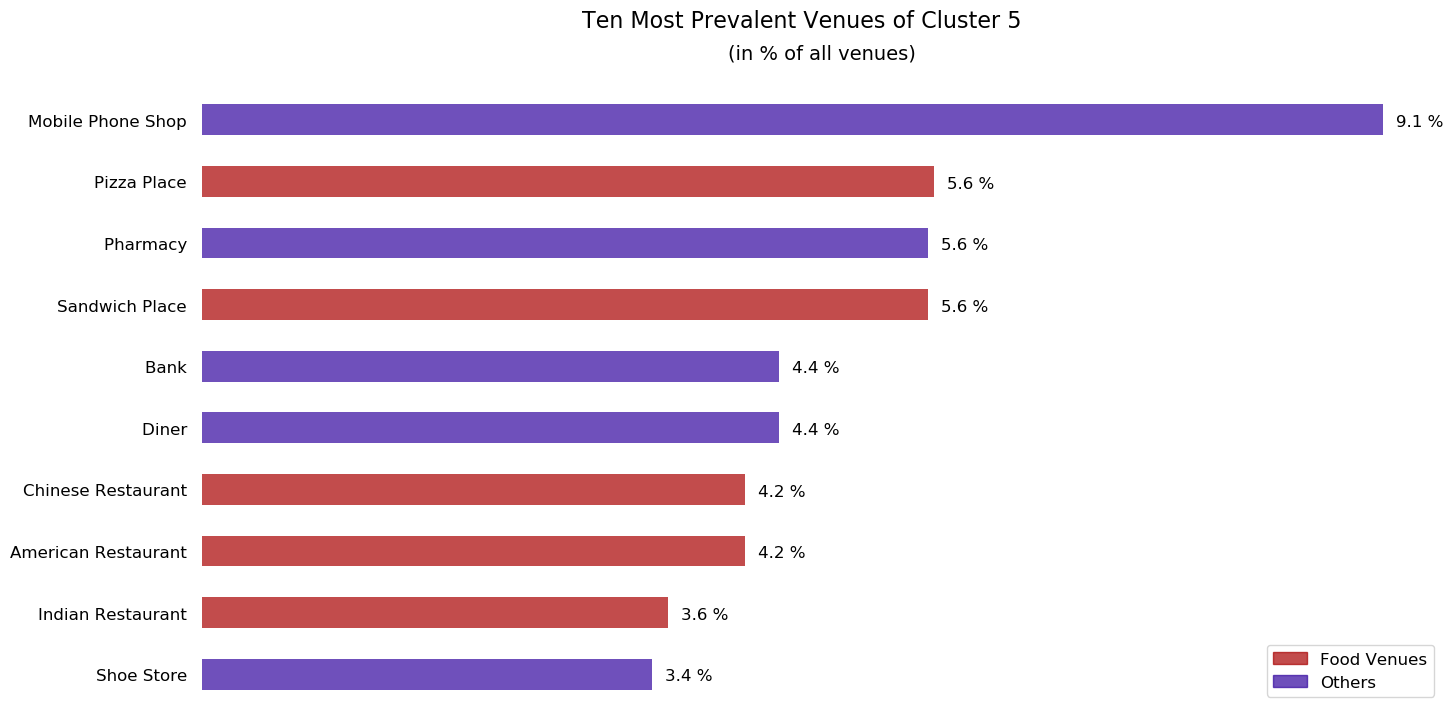

In [110]:
cluster5=pd.DataFrame(la_results.iloc[5,0:-1]).transpose()
cluster5.sort_values(by='Cluster 5',axis=1,ascending=False,inplace=True)
display(cluster5)

clus5=cluster5.iloc[0,9::-1]
generate_plot(clus5,5)